# Mask RCNN Inference and Segmentation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

# Ignore the annoying warnings that come up, there are many of them.
warnings.filterwarnings("ignore")

# Set environment variable CUDA_VISIBLE_DEVICES to "-1" to prevent
# tensorflow from using any GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [104]:
import io
import os
import sys
import random
import math
import re
import time
import json
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage
from skimage.io import imread, imsave
from skimage.transform import resize

import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Custom logging libaries
from ds_toolbox.ds_logging import add_log_file, set_log_level
from ds_toolbox.ds_logging import info, debug, warn, error
set_log_level("debug")

# Import ade20k_coco library
import ade20k_coco
from ade20k_coco import Ade20kCocoConfig, Ade20kCocoDataset

# Ignore Tensorflow Deprecation Warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Ignore additional warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Set SEED for numpy
SEED = 10
np.random.seed(SEED)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# HED Model
Load the model. If `hed_pretrained_bsds.caffemodel` is not found, run the following in the same directory as this notebook:
```
wget http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel
```

In [3]:
prototxt = "deploy.prototxt"
caffemodel = "hed_pretrained_bsds.caffemodel"
target_w = target_h = 500

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

cv2.dnn_registerLayer('Crop', CropLayer)
# Load the model.
net = cv2.dnn.readNet(prototxt, caffemodel)

In [24]:
# TODO: enter relative path to dataset
DATASET_ROOT = os.path.join(ROOT_DIR, "datasets/ade20k_coco_v4") 

dataset_train = ade20k_coco.Ade20kCocoDataset()
dataset_train.load_coco(DATASET_ROOT, "train")

dataset_val = ade20k_coco.Ade20kCocoDataset()
dataset_val.load_coco(DATASET_ROOT, "val")

# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()

n_classes = dataset_train.num_classes

print(f"Image Count (train/val): {len(dataset_train.image_ids)}/{len(dataset_val.image_ids)}")
print("Class Count: {}".format(n_classes))

labelmap = {i['id']: i['name'] for i in dataset_train.class_info}
print(f"Labelmap: {labelmap}")

# Ensure this is correct.
WALL_ID = 3

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Image Count (train/val): 4987/500
Class Count: 5
Labelmap: {0: 'BG', 1: 'ceiling', 2: 'floor, flooring', 3: 'wall', 4: 'windowpane, window'}


In [25]:
%%time

class InferenceConfig(Ade20kCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()
model.load_weights(model_path, by_name=True)

Re-starting from epoch 9
CPU times: user 11 s, sys: 432 ms, total: 11.4 s
Wall time: 10.2 s


04/21/2020 03:35:08 PM [DEBUG] Using image val2014/117.jpg


(1720, 2580, 3)


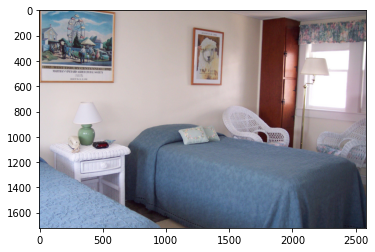

In [26]:
file_id = np.random.choice(dataset_val.image_ids)
file_id = 117
fname = f"/home/mxs8x15/datasets/coco_ade20k_v4/val2014/{file_id}.jpg"
debug(f"Using image val2014/{file_id}.jpg")

real_img = imread(fname)
print(real_img.shape)
plt.imshow(real_img)

In [27]:
%%time
molded_images, image_metas, windows = model.mold_inputs([real_img])
km = model.keras_model

CPU times: user 149 ms, sys: 27 µs, total: 149 ms
Wall time: 148 ms


In [28]:
image_shape = (image_metas.astype(int).squeeze())[4:7]
image_shape

array([1024, 1024,    3])

In [29]:
# image_shape = molded_images[0].shape

# Anchors
anchors = model.get_anchors(image_shape)
# Duplicate across the batch dimension because Keras requires it
# TODO: can this be optimized to avoid duplicating the anchors?
anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)

In [30]:
%%time
# Run object detection
detections, _, _, mrcnn_mask, _, _, _ = km.predict([molded_images,
                                                    image_metas, anchors], verbose=0)

CPU times: user 28.3 s, sys: 801 ms, total: 29.1 s
Wall time: 5.44 s


In [31]:
i = 0
detections = detections[i]
mrcnn_mask = mrcnn_mask[i]

In [32]:
# How many detections do we have?
# Detections array is padded with zeros. Find the first class_id == 0.
zero_ix = np.where(detections[:, 4] == 0)[0]
N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

debug(f"There are {N} detections for image {file_id}.jpg")

# Extract boxes, class_ids, scores, and class-specific masks
boxes = detections[:N, :4]
class_ids = detections[:N, 4].astype(np.int32)
scores = detections[:N, 5]
masks = mrcnn_mask[np.arange(N), :, :, class_ids]

04/21/2020 03:35:15 PM [DEBUG] There are 6 detections for image 117.jpg


In [33]:
scores

array([0.9971131 , 0.995869  , 0.9263491 , 0.92112994, 0.8602892 ,
       0.7117782 ], dtype=float32)

In [34]:
image_shape = (image_metas.astype(int).squeeze())[4:7]
image_shape

array([1024, 1024,    3])

In [35]:
# Convert boxes to pixel coordinates on the original image
denormed_boxes = utils.denorm_boxes(boxes, image_shape[:2])
conf_masks = []

for i in range(N):
    bbox = denormed_boxes[i]
    mask = masks[i]
    y1, x1, y2, x2 = bbox
#     threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = utils.resize(mask, (y2 - y1, x2 - x1))
#     mask = np.where(mask >= threshold, 1, 0).astype(np.bool)
    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2])
    full_mask[y1:y2, x1:x2] = mask
    
    conf_masks.append(full_mask)

In [36]:
stacked_conf_masks = np.array(conf_masks)
stacked_conf_masks.shape

(6, 1024, 1024)

In [37]:
labelmap

{0: 'BG',
 1: 'ceiling',
 2: 'floor, flooring',
 3: 'wall',
 4: 'windowpane, window'}

In [38]:
h, w, _ = image_shape
final_masks = np.zeros((n_classes, h, w))

# Uniform 15% chance of being label 0: BG
final_masks[0] = np.ones((h, w)) * 0.15

In [43]:
for idx in range(N):
    conf_mask = conf_masks[idx]
    label = class_ids[idx]
    final_masks[label] = np.maximum(final_masks[label], conf_mask)

In [44]:
final_masks.shape

(5, 1024, 1024)

## Flood Fill Using Confidences

In [47]:
from colormap import colormap

colors = colormap(maximum=255)
colors.shape

(74, 3)

In [48]:
def highest_weight_label(region_mask, labels, pred_mask, conf_mask,
                        operation="mean"):
    
    region_mask = region_mask[1:-1, 1:-1]
    mask_r, mask_c = np.where(region_mask)

    region_labels = pred_mask[mask_r, mask_c]
    region_confs = conf_mask[mask_r, mask_c]
    
    # Maps labels to the mean confidence for that label.
    weights = {}
    for label in labels:
        idx_mask = (region_labels == label)
        # Take the mean of the confidence values for that label.
        if operation == "median":
            weight = np.median(region_confs[idx_mask])
        else:
            weight = np.mean(region_confs[idx_mask])
        weights[label] = weight
        
    # Find most probable label according to weight
    best_label, highest_weight = max(weights.items(), key=lambda x: x[1])
    return best_label

# Try on Different Images

In [58]:
def create_hed(img):
    inp = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(target_w, target_h),
                           mean=(104.00698793, 116.66876762, 122.67891434),
                           swapRB=False, crop=False)
    net.setInput(inp)
    hed_edges = net.forward()
    hed_edges = hed_edges[0, 0]
    hed_edges = cv2.resize(hed_edges, (img.shape[1], img.shape[0]))
    hed_edges = 255 * hed_edges
    hed_edges = hed_edges.astype(np.uint8)
    hed_edges = cv2.cvtColor(hed_edges, cv2.COLOR_GRAY2BGR)
    return hed_edges

# Use Single Channel Image, No Custom Colors

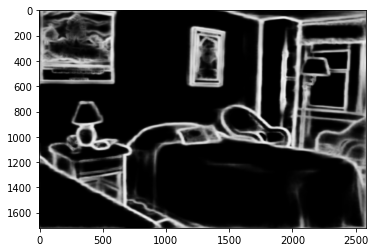

In [149]:
hed_edges = create_hed(img)
plt.imshow(hed_edges)

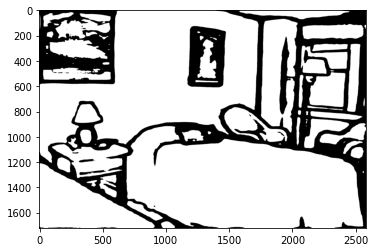

In [157]:
_, edges_thresh = cv2.threshold(hed_edges, 60, 255, cv2.THRESH_BINARY_INV)
plt.imshow(edges_thresh)

In [158]:
def create_filled(img, pred_mask, conf_mask):
    kept_masks = []
    labels = np.unique(pred_mask).tolist()
    labels = [li for li in labels if li != 0] + [0]
    
    hed_edges = create_hed(img)
    _, edges_thresh = cv2.threshold(hed_edges, 60, 255, cv2.THRESH_BINARY_INV)
    h, w, _ = edges_thresh.shape
    
    edges_thresh = edges_thresh[:, :, 0]
    im_floodfill = edges_thresh.copy() 
    
    allowed_labels = set(labels)
    allowed_labels.remove(0)
    
    done = False
    while not done:
        if not allowed_labels:
            done = True
            break

        for label in labels:
            if label not in allowed_labels:
                continue
        
            textlabel = labelmap[label]
    #         print(f"Label is {label}: {textlabel}")
            # Find coordinate of highest confidence
            # Look at only where this label is chosen
            label_mask_r, label_mask_c = np.where(pred_mask == label)
            # Find corresponding confidence values for those locations
            conf_vals = conf_mask[label_mask_r, label_mask_c]

            # Iterate over the most confident pixels assigned this label
            # until we find one that isn't on an edge. Order in descending
            # order.
            idx_ordering = np.argsort(conf_vals)[::-1]

            r = c = None
            for argmax_idx in idx_ordering:
                # Confidence threshold
                conf = conf_vals[argmax_idx]
                if conf <= 0.60:
                    # No more confident pixels for this label, remove
                    # from allowed labels
                    print(f"No more confident locations for label {label, textlabel}")
                    allowed_labels.remove(label)
                    break

                r = label_mask_r[argmax_idx]
                c = label_mask_c[argmax_idx]
                pixel = im_floodfill[r, c]

                if np.all(pixel == 255):
                    # We found an uncolored region
                    break
                else:
                    r = c = None
                    continue

            # Sanity check
            if r is None:
                continue

                # Coordinate must be (x, y) rather than (row, col)
            x = c
            y = r
            coord = (x, y)
            
            mask = np.zeros((h+2, w+2), np.uint8)
#             color = (colors[label, :]).tolist()
            color = label + 1
            cv2.floodFill(im_floodfill, mask, coord, color)

            # Sanity check: take this mask, get the most common label within it
            try:
                mode_label = highest_weight_label(mask, labels, pred_mask, conf_mask,
                                                 operation="median")
            except:
                mode_label = -1
            
            if mode_label != -1:
#                 color = (colors[mode_label, :]).tolist()
                color = mode_label + 1
                im_floodfill[mask] = color

            plt.figure()
#             plt.title(textlabel)
            plt.imshow(im_floodfill)


    # Final post-processing step: Ensure the mask is range [0, NUM_CLASSES]
    msk = im_floodfill == 255
    im_floodfill[msk] = 0
    im_floodfill = im_floodfill.astype(np.int32) - 1
    im_floodfill = np.clip(im_floodfill, 0, 255)
    pred_mask = im_floodfill.astype(np.uint8)

    return edges_thresh, pred_mask

In [232]:
# def process_sample(sample_num):
#     img_scaled_fpath = f"tmp/sample{sample_num}_img_scaled_v4.jpg"
#     img_fpath = f"tmp/sample{sample_num}_img_v4.jpg"
#     mask_fpath = f"tmp/sample{sample_num}_pred_mask_v4.npy"
#     conf_fpath = f"tmp/sample{sample_num}_conf_mask_v4.npy"
#     gt_fpath = f"tmp/sample{sample_num}_gt_mask_v4.npy"

#     img  = imread(img_fpath)
#     img_scaled = imread(img_scaled_fpath)
#     pred_mask = np.load(mask_fpath)
#     conf_mask = np.load(conf_fpath)
#     gt_mask = np.load(gt_fpath).astype(np.uint8)
    
#     edges_thresh, pred_mask = create_filled(img_scaled, img, pred_mask, conf_mask)
#     return (img_scaled, img, gt_mask, edges_thresh, pred_mask)


def process_sample(img, final_masks):
#     img_scaled_fpath = f"tmp/sample{sample_num}_img_scaled_v4.jpg"
#     img_fpath = f"tmp/sample{sample_num}_img_v4.jpg"
#     mask_fpath = f"tmp/sample{sample_num}_pred_mask_v4.npy"
#     conf_fpath = f"tmp/sample{sample_num}_conf_mask_v4.npy"
#     gt_fpath = f"tmp/sample{sample_num}_gt_mask_v4.npy"
    
    pred_mask = np.argmax(final_masks, axis=-1)
    conf_mask = np.max(final_masks, axis=-1)
    
    edges_thresh, pred_mask = create_filled(img, pred_mask, conf_mask)
    return (img, edges_thresh, pred_mask)


def disp_results(file_id, img, edges_thresh, pred_mask):
    plt.figure(dpi=300)
    plt.suptitle(f"Sample number {file_id}")
    plt.subplot(2, 2, 1)
    plt.imshow(img)
    
    plt.subplot(2, 2, 2)
    plt.imshow(edges_thresh)
    
    plt.subplot(2, 2, 3)
    plt.imshow(pred_mask)
    
    plt.subplot(2, 2, 4)
    
    present_classes = np.unique(pred_mask)
    n_present_classes = len(present_classes)
    legend = np.zeros((400, 400*n_present_classes), np.uint8)
    words = []
    title = ""
    for i in present_classes:
        legend[:, 400*i: 400*(i+1)] = i
        label = labelmap[i]
        # Keep final word in multi-word label
        last_word = label.split(",")[-1]
        words.append(last_word)

    plt.axis("off")
    plt.title(' | '.join(words))
    plt.imshow(legend)
    
    
#     legend = np.zeros((400, 400*n_classes), np.uint8)
#     words = ["     ", ]
#     title = ""
#     for i in range(n_classes):
#         legend[:, 400*i: 400*(i+1)] = i
#         label = labelmap[i]
#         last_word = label.split(",")[-1]
#         words.append(last_word)

#     plt.axis("off")
#     plt.title(' | '.join(words))
#     plt.imshow(legend)

In [143]:
def recolor_naive(img, pred_mask, color_uint8):
    plt.figure()
    color_showcase = np.ones((200, 200, 3), np.uint8) * color_uint8
    plt.title("Recolor Color")
    plt.imshow(color_showcase)
    
    # Naive Recoloring
    (h, w, c) = img.shape
    scaled_mask = skimage.transform.resize(pred_mask, (h, w), 
                                           mode='symmetric',
                                           preserve_range=True).astype(np.uint8)
    
    wall_mask = (scaled_mask == WALL_ID)
    
    w = 0.35
    naive_recolor = img.copy()
    naive_recolor[wall_mask, :] = (w * color_uint8) + ((1 - w) * img[wall_mask, :])
    naive_recolor = np.clip(naive_recolor, 0, 255)
    
    plt.figure(dpi=100)
    plt.title("Naive Recolor")
    plt.imshow(naive_recolor)
    
def recolor_using_hsv(img, pred_mask, color_uint8, alpha=0.4, beta=0.15):
    
#     img = img.astype(np.float64) / 255.0
#     color_float = color_uint8.astype(np.float64) / 255.0
    color_float = color_uint8

    
    (h, w, c) = img.shape
    scaled_pred_mask = skimage.transform.resize(pred_mask, (h, w), 
                                                mode='symmetric',
                                                preserve_range=True).astype(np.uint8)
    
    wall_mask = (scaled_pred_mask == WALL_ID)

    # HSV Recoloring
    hsv_img = skimage.color.rgb2hsv(img)
#     plt.figure(dpi=120)
#     plt.title(f"HSV Img")
#     plt.imshow(hsv_img)
    
    
    hsv_recolor = hsv_img.copy()
    # rgb2hsv() requires image, so just reshape array into 1 x 1 x 3
    hsv_color = skimage.color.rgb2hsv(color_float.reshape((1, 1, 3)))
    hsv_color = hsv_color.reshape((3))

    # Hue
    hsv_recolor[wall_mask, 0] = (alpha * hsv_color[0]) + (1.0 - alpha) * hsv_img[wall_mask, 0]
    
    # Saturation
    hsv_recolor[wall_mask, 1] = (alpha * hsv_color[1]) + (1.0 - alpha) * hsv_img[wall_mask, 1]
    
    # Value
    hsv_recolor[wall_mask, 2] = ((alpha - beta) * hsv_color[2]) + ((1.0 - alpha + beta) 
                                                                * hsv_img[wall_mask, 2])

    hsv_recolor = np.clip(skimage.color.hsv2rgb(hsv_recolor), 0.0, 1.0)
    plt.figure(dpi=100)
    plt.title(f"HSV Recolor: alpha={alpha} beta={beta}")
    plt.imshow(hsv_recolor)

In [144]:
def recolor_new(img, pred_mask, color_uint8, alpha=0.4, beta=0.15):
    
    (h, w, c) = img.shape
    scaled_pred_mask = skimage.transform.resize(pred_mask, (h, w), 
                                                mode='symmetric',
                                                preserve_range=True).astype(np.uint8)
    
    wall_mask = (scaled_pred_mask == WALL_ID)
    rows, cols = np.where(wall_mask)
    channels = np.zeros(len(rows), np.uint8)
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    

    # HSV Recoloring
    # hsv_img = skimage.color.rgb2hsv(img)
    
    
    hsv_recolor = hsv_img.copy()
    # rgb2hsv requires image, so just reshape array into 1 x 1 x 3
    hsv_color = cv2.cvtColor(color_uint8.reshape((1, 1, 3)), cv2.COLOR_RGB2HSV)
    hsv_color = hsv_color.reshape((3,))

    # Hue
    channels[:] = 0
    hsv_recolor[rows, cols, channels] = (alpha * hsv_color[0]) + (
                                        (1.0 - alpha) * hsv_img[rows, cols, channels])
    
    # Saturation
    channels[:] = 1
    hsv_recolor[rows, cols, channels] = (alpha * hsv_color[1]) + (
                                        (1.0 - alpha) * hsv_img[rows, cols, channels])
    
    # Value
    channels[:] = 2
    hsv_recolor[rows, cols, channels] = ((alpha - beta) * hsv_color[2]) + (
                                        (1.0 - (alpha - beta)) * hsv_img[rows, cols, channels])

    recolored = cv2.cvtColor(hsv_recolor, cv2.COLOR_HSV2RGB)
#     hsv_recolor = skimage.color.hsv2rgb(hsv_recolor)
    plt.figure(dpi=100)
    plt.title(f"HSV Recolor: alpha={alpha} beta={beta}")
    plt.imshow(recolored)

In [145]:
# color_uint8 = np.array([0, 100, 0]).astype(np.uint8)
# recolor_naive(img_scaled, img, gt_mask, pred_mask, color_uint8)
# recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.5, beta=0.15)
# recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.6, beta=0.15)
# recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.6, beta=0.25)

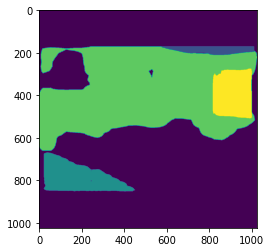

In [160]:
pred_mask = np.argmax(final_masks, axis=0)
plt.imshow(pred_mask)

In [ ]:
keep_im_floodfill = None

In [202]:
def create_filled(img, pred_mask, conf_mask):
    labels = np.unique(pred_mask).tolist()
    labels = [li for li in labels if li != 0] + [0]
    
    hed_edges = create_hed(img)
    _, edges_thresh = cv2.threshold(hed_edges, 70, 255, cv2.THRESH_BINARY_INV)
    h, w, _ = edges_thresh.shape
    
    edges_thresh = edges_thresh[:, :, 0]
    im_floodfill = edges_thresh.copy() 
    
    allowed_labels = set(labels)
    allowed_labels.remove(0)
    
    done = False
    while not done:
        if not allowed_labels:
            done = True
            break

        for label in labels:
            if label not in allowed_labels:
                continue
        
            textlabel = labelmap[label]
    #         print(f"Label is {label}: {textlabel}")
            # Find coordinate of highest confidence
            # Look at only where this label is chosen
            label_mask_r, label_mask_c = np.where(pred_mask == label)
            # Find corresponding confidence values for those locations
            conf_vals = conf_mask[label_mask_r, label_mask_c]

            # Iterate over the most confident pixels assigned this label
            # until we find one that isn't on an edge. Order in descending
            # order.
            idx_ordering = np.argsort(conf_vals)[::-1]

            r = c = None
            for argmax_idx in idx_ordering:
                # Confidence threshold
                conf = conf_vals[argmax_idx]
                if conf <= 0.60:
                    # No more confident pixels for this label, remove
                    # from allowed labels
                    print(f"No more confident locations for label {label, textlabel}")
                    allowed_labels.remove(label)
                    break

                r = label_mask_r[argmax_idx]
                c = label_mask_c[argmax_idx]
                pixel = im_floodfill[r, c]

                if np.all(pixel == 255):
                    # We found an uncolored region
                    break
                else:
                    r = c = None
                    continue

            # Sanity check
            if r is None:
                continue

                # Coordinate must be (x, y) rather than (row, col)
            x = c
            y = r
            coord = (x, y)
            
            mask = np.zeros((h+2, w+2), np.uint8)
#             color = (colors[label, :]).tolist()
            color = label
            cv2.floodFill(im_floodfill, mask, coord, color)

            # Sanity check: take this mask, get the most common label within it
            try:
                mode_label = highest_weight_label(mask, labels, pred_mask, conf_mask,
                                                 operation="median")
            except:
                mode_label = -1
            
            if mode_label != -1:
#                 color = (colors[mode_label, :]).tolist()
                color = mode_label + 1
                im_floodfill[mask] = color

#             plt.figure()
#             plt.title(textlabel)
#             plt.imshow(im_floodfill)


    global keep_im_floodfill
    keep_im_floodfill = im_floodfill.copy()
    # Final post-processing step: Ensure the mask is range [0, NUM_CLASSES]
    msk = im_floodfill == 255
    im_floodfill[msk] = 0
#     im_floodfill = im_floodfill.astype(np.int32) - 1
    im_floodfill = np.clip(im_floodfill, 0, 255)
    pred_mask = im_floodfill.astype(np.uint8)

    return (edges_thresh, pred_mask)

In [204]:
final_masks.shape

(5, 1024, 1024)

In [211]:

next_masks.shape

(1024, 1024, 5)

In [212]:


out_masks.shape

(1720, 2580, 5)

In [222]:
image_metas[0].astype(int)

array([   0, 1720, 2580,    3, 1024, 1024,    3,  170,    0,  853, 1024,
          0,    0,    0,    0,    0,    0])

In [223]:
sr, sc, er, ec = (image_metas[0].astype(int))[7:11]
sr, sc, er, ec

(170, 0, 853, 1024)

In [225]:
cropped_masks = final_masks[:, sr:er, sc:ec]
cropped_masks.shape

(5, 683, 1024)

In [227]:
next_masks = np.transpose(final_masks, axes=[1, 2, 0])
out_masks = skimage.transform.resize(next_masks, real_img.shape[:2])

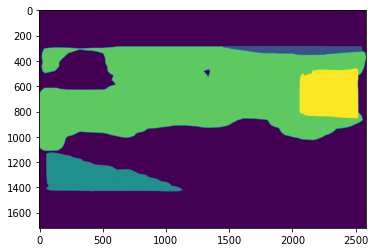

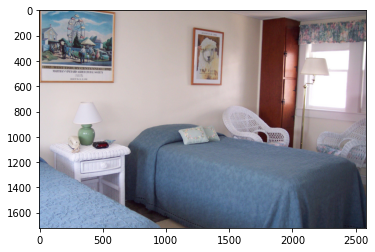

In [229]:
plt.figure(); plt.imshow(np.argmax(out_masks, axis=-1))
plt.figure(); plt.imshow(real_img)

No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (1, 'ceiling')
No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (3, 'wall')


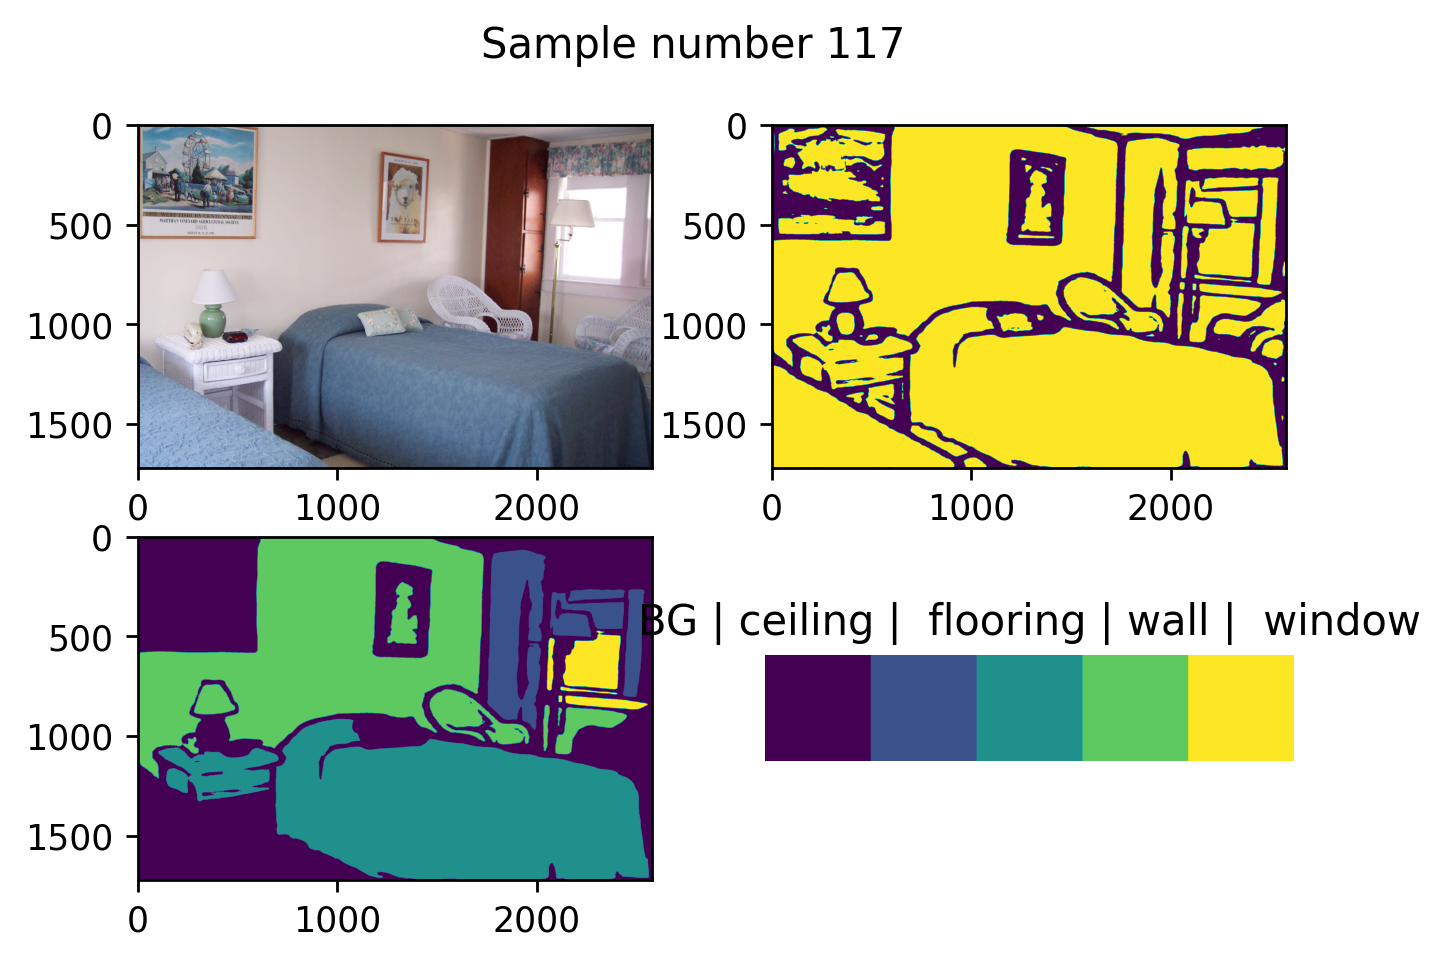

In [230]:
img = real_img
# next_masks = np.transpose(final_masks, axes=[1, 2, 0])
# out_masks = skimage.transform.resize(next_masks, img.shape[:2])

(img, edges_thresh, pred_mask) = process_sample(img, out_masks)
disp_results(file_id, img, edges_thresh, pred_mask)

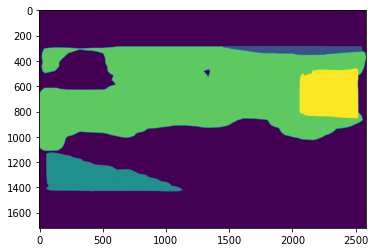

In [215]:
plt.imshow(np.argmax(out_masks, axis=-1))

In [200]:
labelmap

{0: 'BG',
 1: 'ceiling',
 2: 'floor, flooring',
 3: 'wall',
 4: 'windowpane, window'}

In [192]:
green = np.array([51, 206, 96]).astype(np.uint8)
silver = np.array([169, 169, 169]).astype(np.uint8)
purple = np.array([178, 102, 255]).astype(np.uint8)
color_uint8 = purple

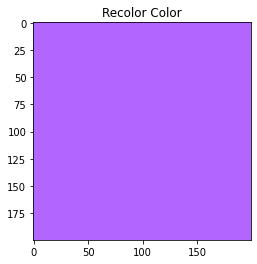

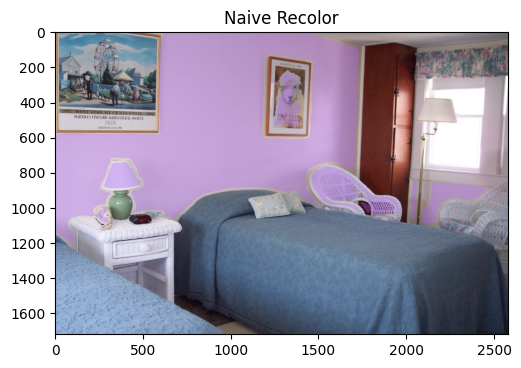

In [231]:
WALL_ID = 3
recolor_naive(img, pred_mask, color_uint8)

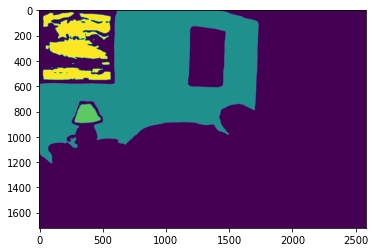

In [186]:
cp_keep_im_floodfill = keep_im_floodfill.copy()
cp_keep_im_floodfill[cp_keep_im_floodfill == 255] = 0
plt.imshow(cp_keep_im_floodfill)

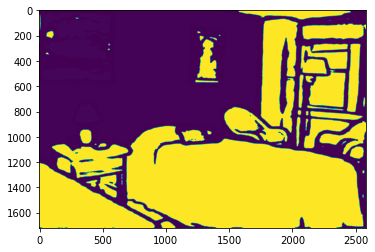

No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (1, 'ceiling')
No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (3, 'wall')


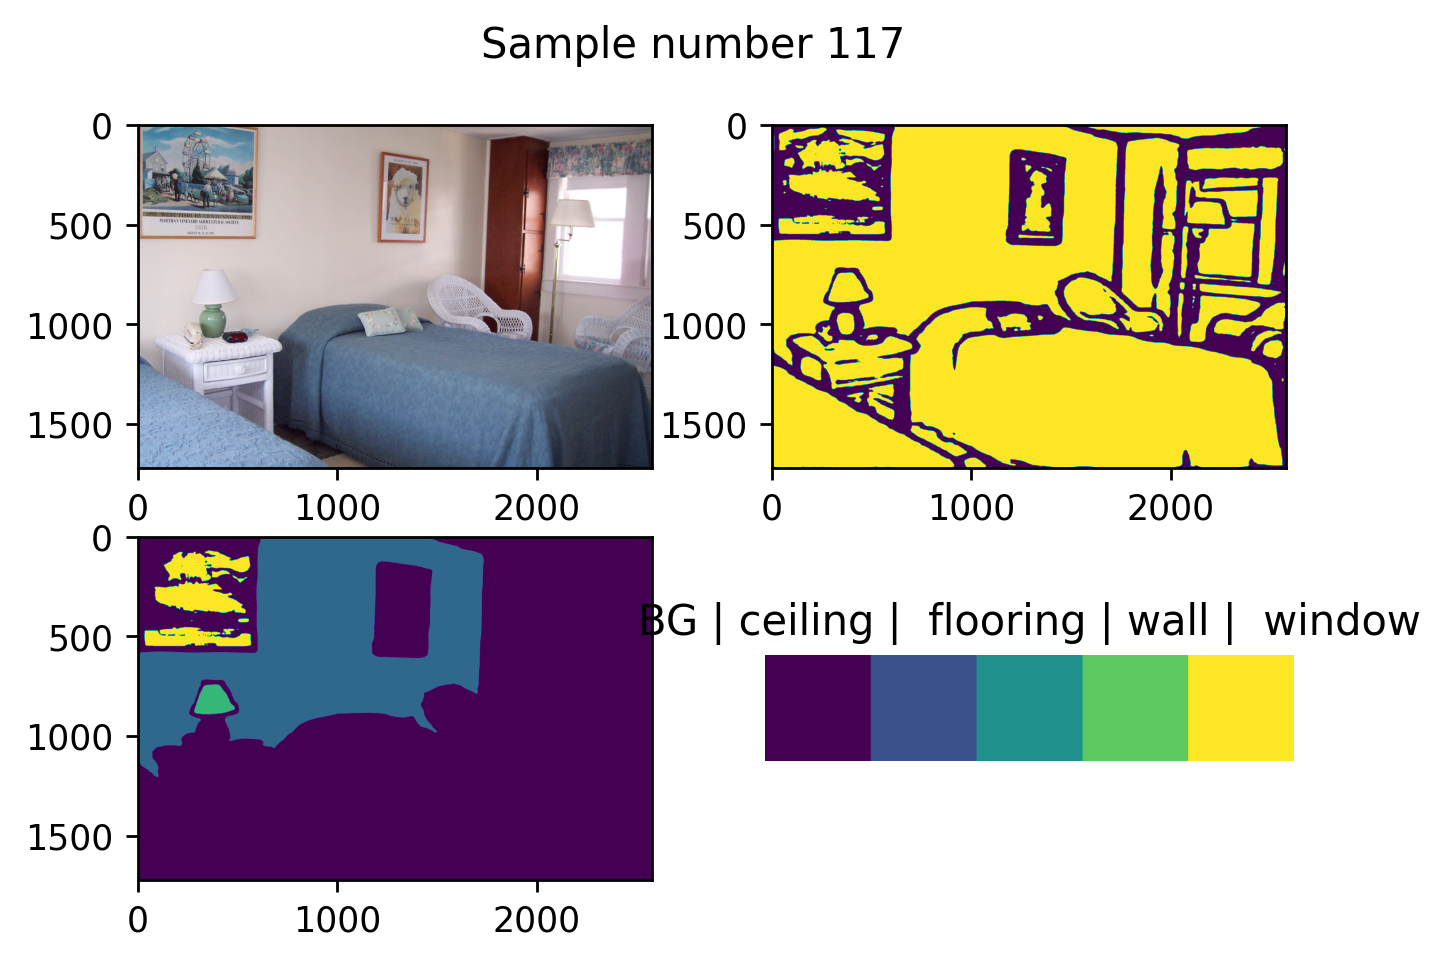

In [146]:
img = real_img
(img, edges_thresh, pred_mask) = process_sample(img, final_masks)
disp_results(file_id, img, edges_thresh, pred_mask)

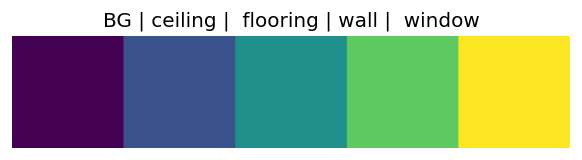

In [139]:
legend = np.zeros((400, 400*n_classes), np.uint8)
words = []
title = ""
for i in range(n_classes):
    legend[:, 400*i: 400*(i+1)] = i
    label = labelmap[i]
    last_word = label.split(",")[-1]
    words.append(last_word)
    
plt.figure(dpi=120)
plt.axis("off")
plt.title(' | '.join(words))
plt.imshow(legend)

No more confident locations for label (1, 'ceiling')
No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (3, 'wall')
No more confident locations for label (1, 'ceiling')
No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (3, 'wall')
No more confident locations for label (1, 'ceiling')
No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (3, 'wall')
No more confident locations for label (1, 'ceiling')
No more confident locations for label (4, 'windowpane, window')
No more confident locations for label (2, 'floor, flooring')
No more confident locations for label (3, 'wall')
No more confident locations for label (2, 'floor, flooring')
No more confident locations

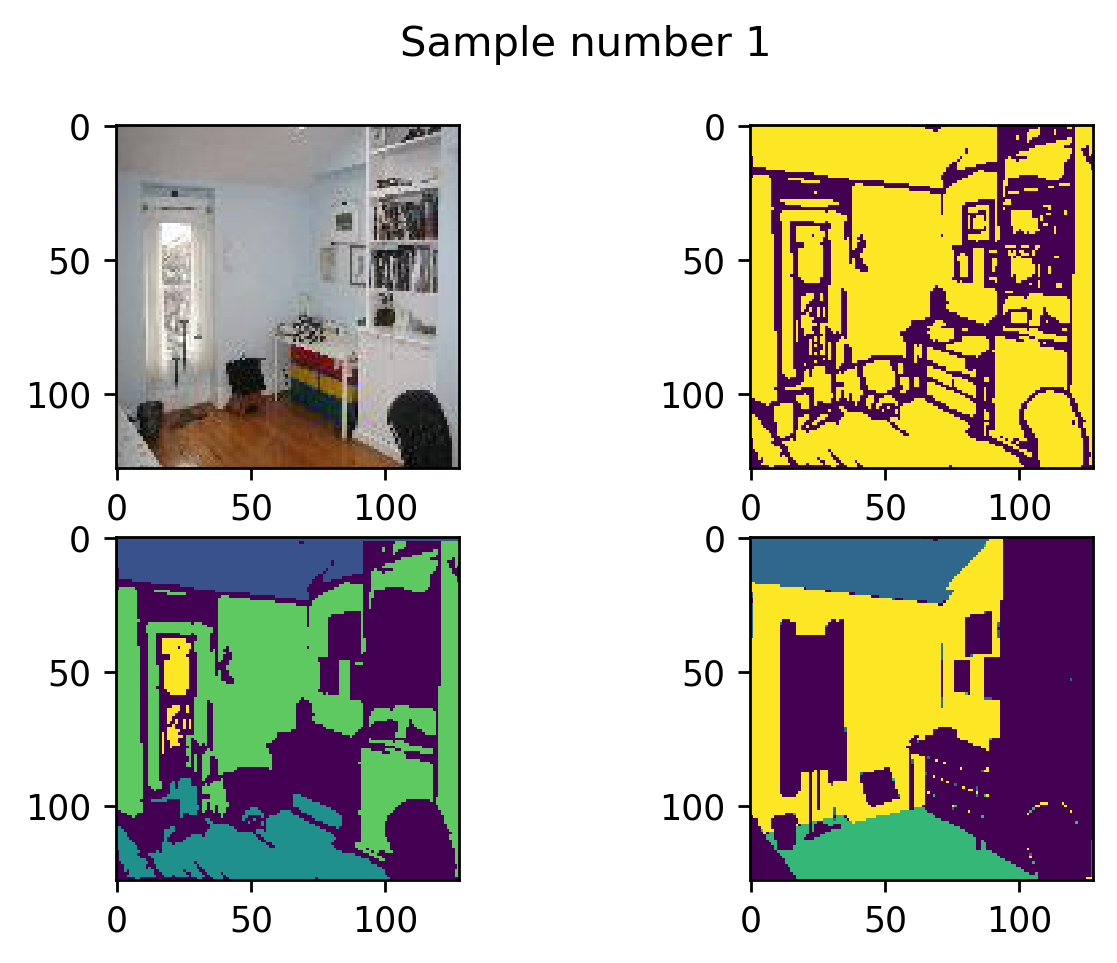

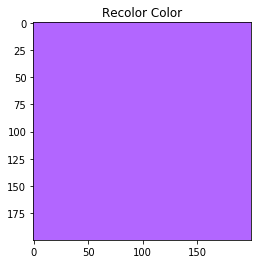

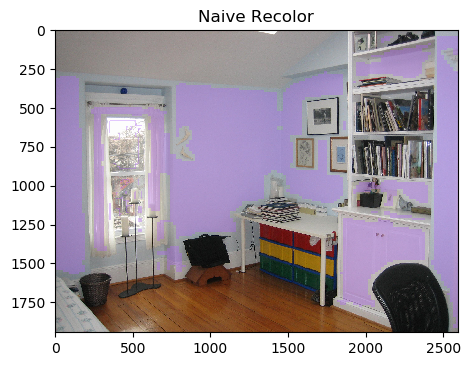

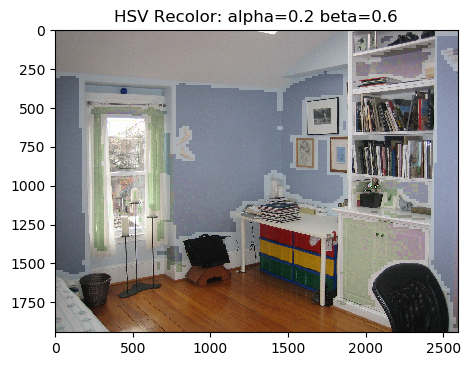

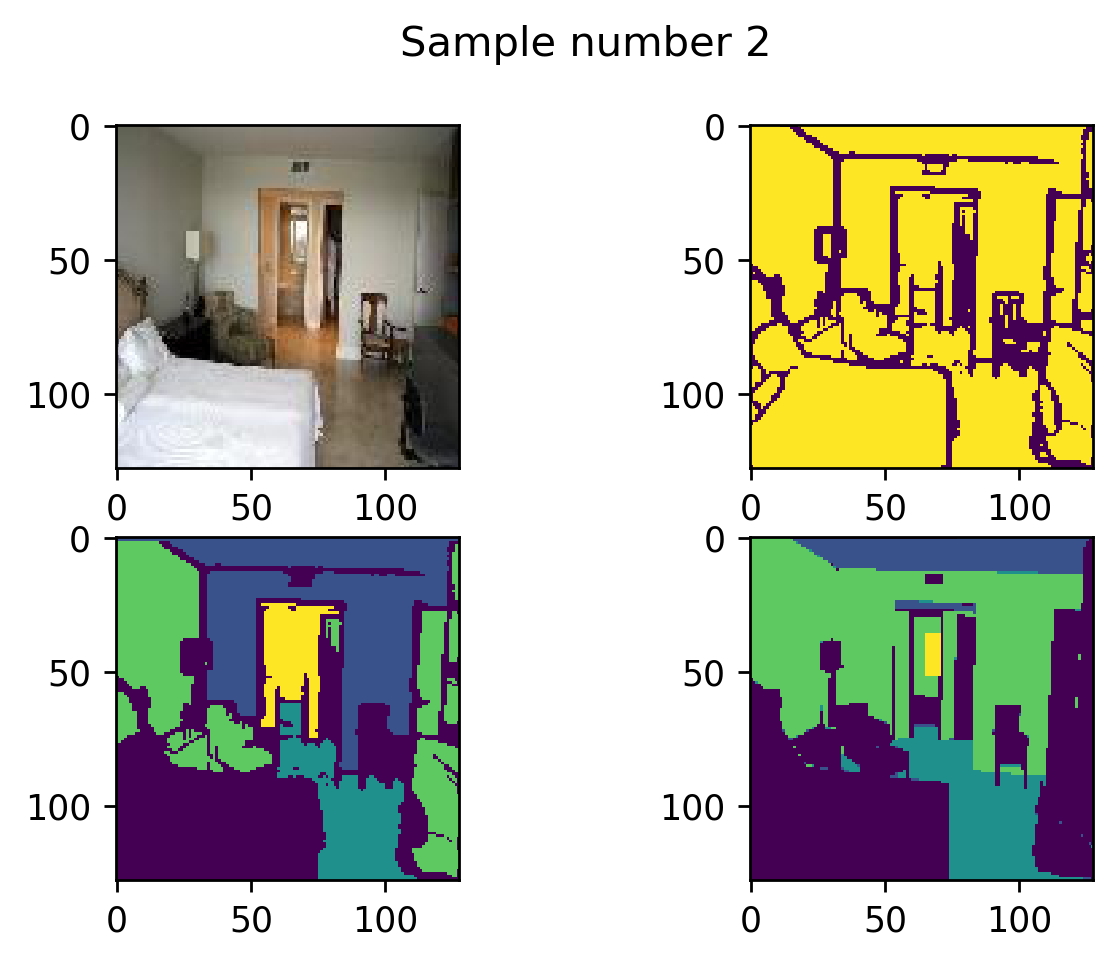

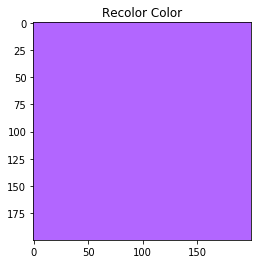

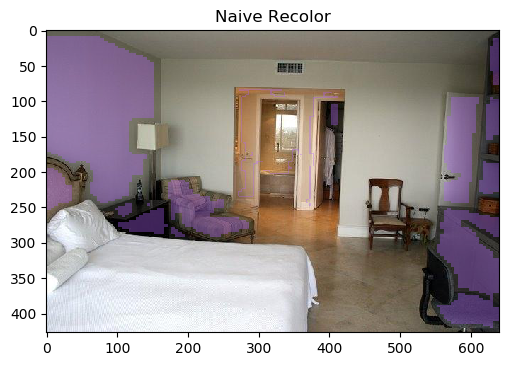

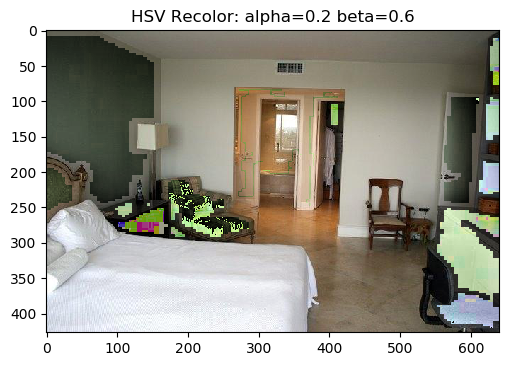

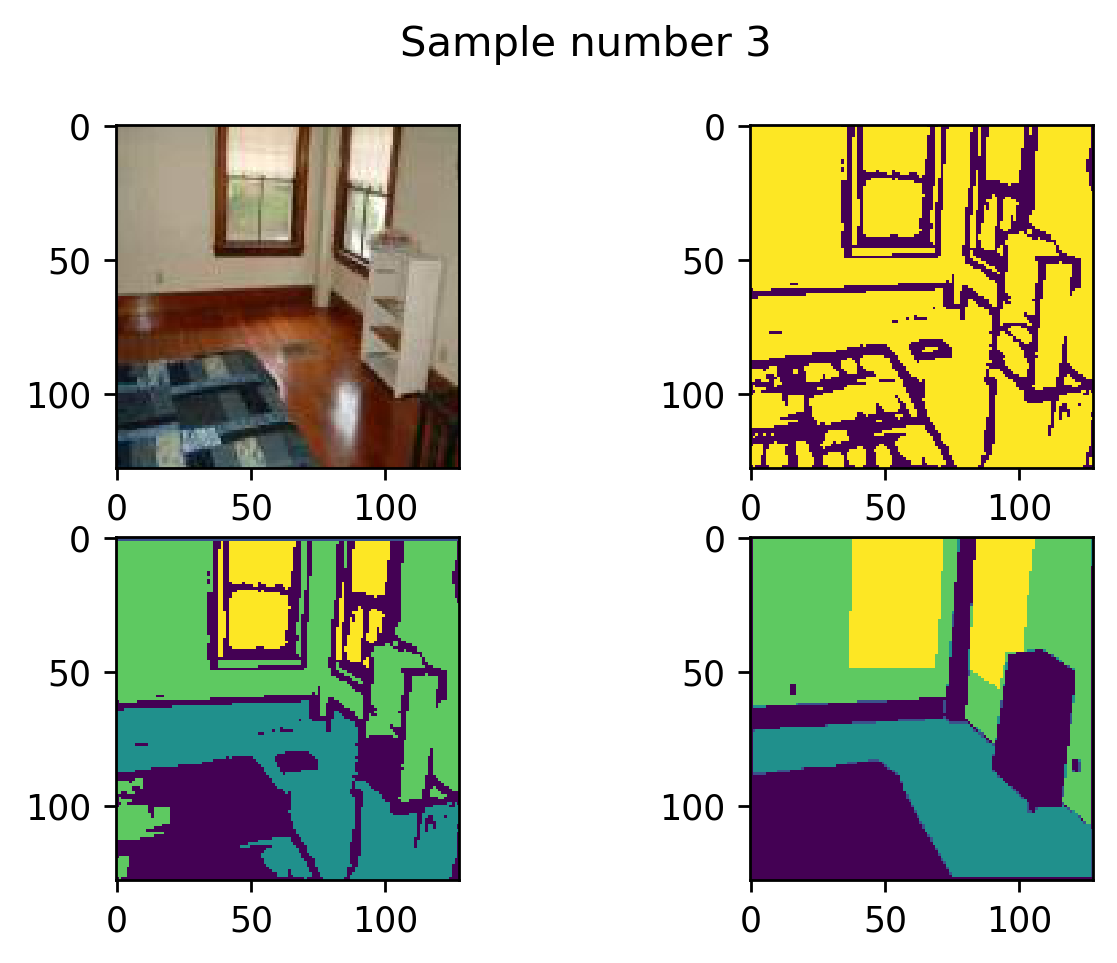

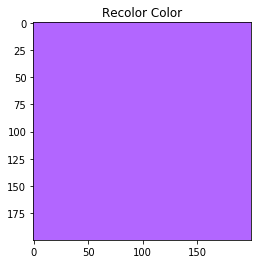

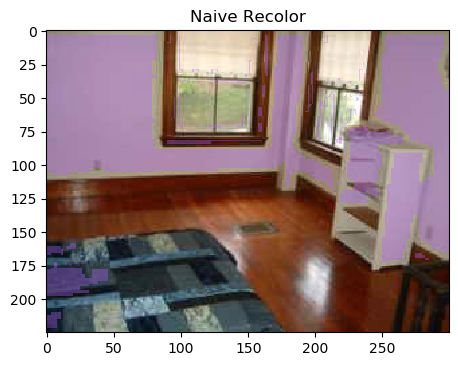

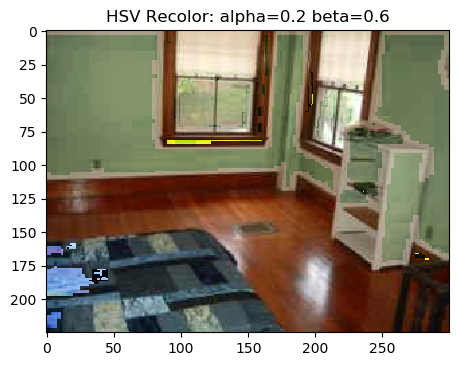

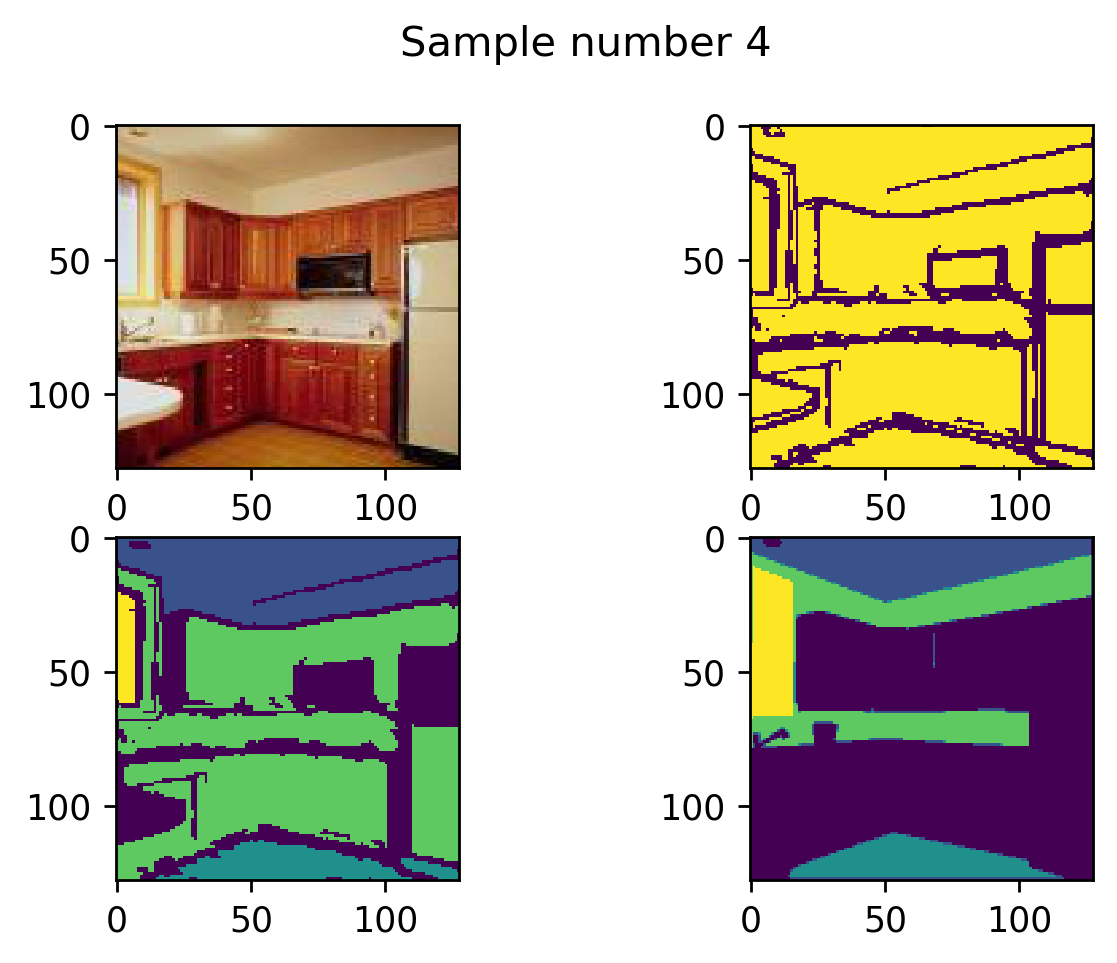

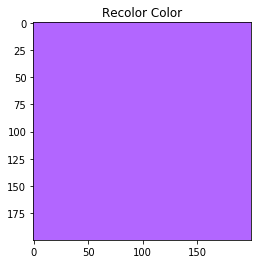

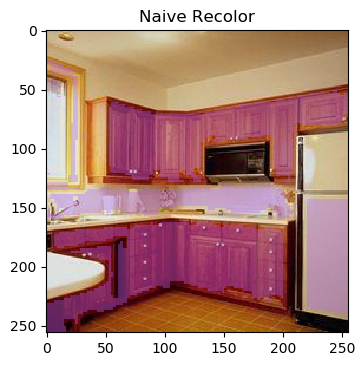

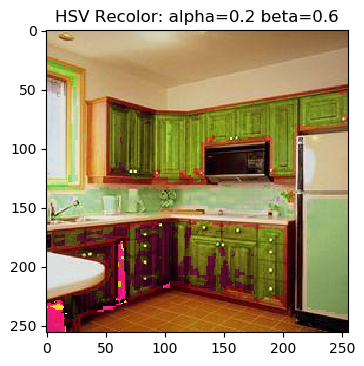

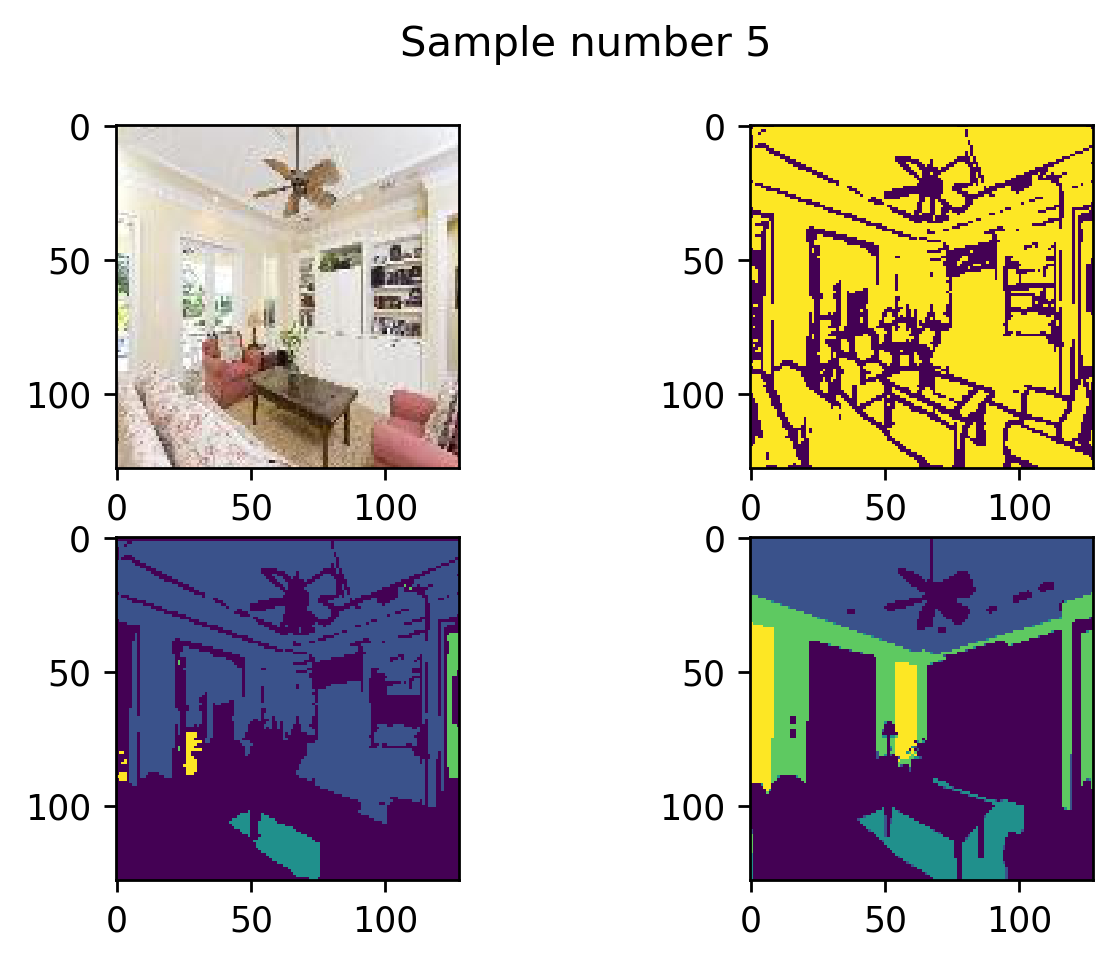

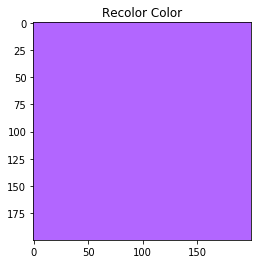

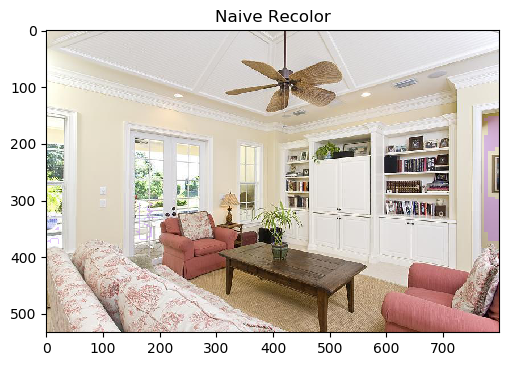

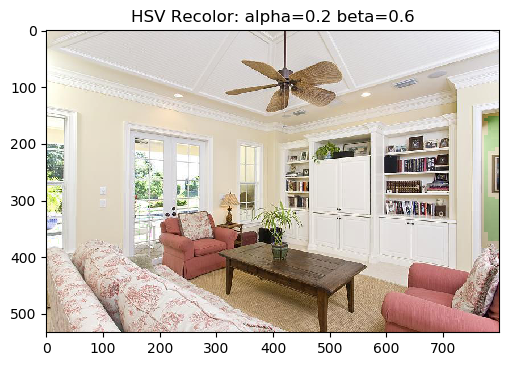

In [182]:
n_samples = 5
green = np.array([51, 206, 96]).astype(np.uint8)
silver = np.array([169, 169, 169]).astype(np.uint8)
purple = np.array([178, 102, 255]).astype(np.uint8)
color_uint8 = purple

for sample_num in range(n_samples):
    sample_num += 1
    (img_scaled, img, gt_mask, edges_thresh, pred_mask) = process_sample(sample_num)
    disp_results(sample_num, img, gt_mask, edges_thresh, pred_mask)
    
    recolor_naive(img_scaled, img, gt_mask, pred_mask, color_uint8)
    recolor_new(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.2, beta=0.6)
#     recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.5, beta=0.1)
#     recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.6, beta=0.25)

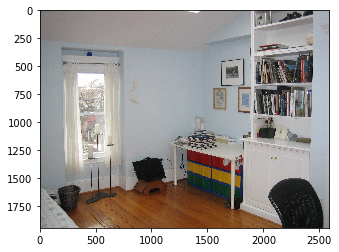

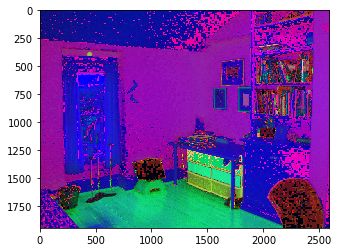

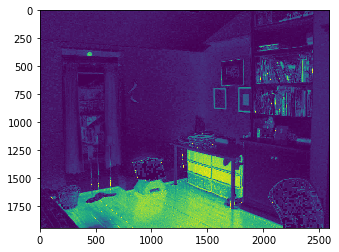

In [158]:

plt.figure()
plt.imshow(img_scaled)

hsv_scaled = skimage.color.rgb2hsv(img_scaled)
plt.figure()
plt.imshow(hsv_scaled)

plt.figure()
plt.imshow(hsv_scaled[:, :, 1])

In [ ]:
recolor_using_hsv(img_scaled, img, gt_mask, pred_mask, color_uint8, alpha=0.7, beta=0.3)

In [14]:
(h, w, c) = img_scaled.shape
scaled_mask = skimage.transform.resize(pred_mask, (h, w), preserve_range=True).astype(np.uint8)
scaled_wall_mask = (scaled_mask == WALL_ID)

In [20]:
green = np.array([51, 206, 96])
color = green
color_float = green.astype(np.float16) / 255.0
bad_recolor = img_scaled.copy()

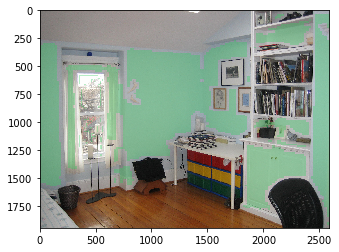

In [23]:
w = 0.35
bad_recolor[scaled_wall_mask, :] = (w * color) + ((1 - w) * img_scaled[scaled_wall_mask, :])
bad_recolor = np.clip(bad_recolor, 0, 255)
plt.imshow(bad_recolor)

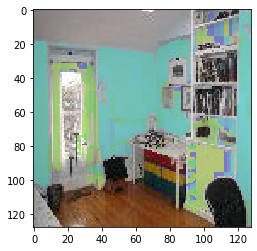

In [60]:
a = 0.5
b = 0.2

small_wall_mask = (pred_mask == WALL_ID)

hsv_color = skimage.color.rgb2hsv(color_float.reshape((1, 1, 3))).flatten()
hsv_recolor = skimage.color.rgb2hsv(img.copy().astype(np.float64) / 255.0)

hsv_recolor[small_wall_mask, 0] = (a * hsv_color[0]) + (1 - a) * hsv_recolor[small_wall_mask, 0]
hsv_recolor[small_wall_mask, 1] = (a * hsv_color[1]) + (1 - a) * hsv_recolor[small_wall_mask, 1]
hsv_recolor[small_wall_mask, 2] = (a * hsv_color[2]) + (1 - a) * hsv_recolor[small_wall_mask, 2]


hsv_recolor = np.clip(hsv_recolor, 0.0, 1.0)
hsv_recolor = skimage.color.hsv2rgb(hsv_recolor)

# plt.figure(dpi=200)
plt.imshow(hsv_recolor)